# **Mô tả vấn đề**

## **1. Thiết lập vấn đề**
Chúng ta sẽ giải phương trình mặt tiến dầu nước Buckley - Leverett

Đối với các phương trình bảo toàn vô hướng không lồi, có thể viết điều kiện entropy Oleinik như sau:

$$
\frac{f(u) - f(u_l)}{u - u_l} \geq \sigma \geq \frac{f(u) - f(u_r)}{u - u_r}
$$

trong đó \( u_{l,r} \) là các giá trị bão hòa ngay trước và sau điểm gián đoạn, và 𝜎 là vận tốc sốc được định nghĩa như sau:

$$
\sigma = f'(u^*) = \frac{f(u^*)}{u^*}
$$

Vì vậy, chúng ta cần tìm một giá trị \( u \) cụ thể (được gọi là \( u^* \)) sao cho:

$$
f'_w (u^*) - \frac{f_w (u^*)}{u^*} = 0
$$

Nghiệm của phương trình này là:

$$
u^* = \sqrt{\frac{1}{(1+M)}}
$$

(Xem phần phụ lục để biết thêm chi tiết)

Trong phương trình đạo hàm riêng (PDE), chúng ta sẽ thay đổi $f_w$ thành $\tilde{f}_w$, được viết như sau:

$$
\tilde{f}_w (u) =
\begin{cases} 
\sigma u & 0 \leq u < u^* \\
f_w (u) & u \geq u^*
\end{cases}
$$

Và chúng ta sẽ giải phương trình PDE mới:

$$
u_t + (\tilde{f}_w)_x = 0
$$

Nghiệm chính xác của phương trình:

Đối với cấu hình được hiển thị, chúng ta có thể sử dụng nghiệm giải tích sau đây [3] với giả thiết rằng $ξ= x/t$:

$
u(x,t) = u(\xi) =
\begin{cases} 
\frac{1}{2} \left( \sqrt{\left( \frac{-2\xi + \sqrt{4\xi+1} - 1}{\xi} \right)} + 1 \right) + 1, & \xi \leq \frac{1}{2} (1 + \sqrt{2}), \\
0, & \text{otherwise}.
\end{cases}
$


# **2. Cách thực hiện**
Mô tả này đi qua việc thực hiên một bộ giải cho từng bước được mô tả ở trên

### *2.1. Import các thư viện cần thiết*

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


### *2.2. Chúng ta sẽ bắt đầu định nghĩa các tham số của phương trình*

In [2]:
# Định nghĩa các hằng số và tham số vỉa dầu
# Thiết lập độ chính xác
dde.config.set_default_float("float64")

# Đặt seed để tái lập
np.random.seed(1234)
tf.random.set_seed(1234)

# Định nghĩa các tham số vật lý
L = 1000  # Kích thước vỉa (m)
A = 100  # Diện tích mặt cắt (m²)
phi = 0.2  # Độ rỗng đồng nhất
k = 100e-15  # Độ thấm đồng nhất (m²)
v = 0.5  # Vận tốc Darcy (m/day)
M = 1.0  # Tỷ số độ nhớt (mu_o / mu_w)
mu_w = 1e-3  # Độ nhớt nước (Pa.s)
mu_o = M * mu_w  # Độ nhớt dầu (Pa.s)
Q_w_inj = 20  # Lưu lượng bơm ép nước (m³/day)
Q_prod = 20  # Lưu lượng khai thác (m³/day)
t_simulate = 1000  # Thời gian mô phỏng (days)

Set the default float type to float64


### *2.3. Tạo hàm nghiệm chính xác của phương trình Buckley Leverett*

In [3]:
# Thiết lập độ chính xác
dde.config.set_default_float("float64")

# Đặt seed để tái lập
np.random.seed(1234)

# Định nghĩa hàm nghệm chính xác trong phương trình Buckley Leverett
def BL_exact_solution(x, t):
    Sw = 0
    if t == 0:
        Sw = 0
    elif x == 0 and t > 0:
        Sw = 1 
    elif x < (1/2) * (1 + np.sqrt(2)) * t:
        e = x / t
        Sw = (1/2) * (np.sqrt((-2 * e + np.sqrt(4 * e + 1) - 1)/e + 1) +1)
    return Sw

# Định nghĩa hàm nghiệm chính xác theo các điểm trong không gian và thời gian
def gen_exact_solution():
    """Sinh nghiệm chính xác của phương trình Buckley Leverett tại các trị x và t đã cho"""
    # Số lượng điểm từng chiều (khôn gian và thời gian)
    x_dim, t_dim = (500, 500)   # 500 điểm trên trục x, 500 điểm trên trục t
    # Giới hạn của x và t
    x_min, t_min = (0, 0)
    x_max, t_max = (L, t_simulate)
    # Tạo mảng x và t với các giá trị được chia đều trong phạm vi đã chỉ định
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)  # Chia t thành 500 điểm, reshape để dễ xử lý
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)  # Chia x thành 500 điểm
    # Khởi tạo mảng 2D để lưu nghiệm chính xác
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)
    # Duyệt qua từng điểm trong không gian và thời gian để tính nghiệm
    for i in range(x_dim):
        for j in range (t_dim):
            usol[i][j] = BL_exact_solution(x[i], t[j])  # Tính nghiệm tại (x, t)
    # Lưu dữ liệu nghiệm chĩnh xác vào file.npz để sử dụng sau này
    np.savez("BK_eq_data", x=x, t=t, usol=usol)

# Hàm nhập và xử lý dữ liệu nghiệm chính xác đã được lưu trữ
def gen_testdata():
    """Nhập và tiền xử lý tập dữ liệu chứa nghiệm chính xác."""
    # Nạp dữ liệu từ file đã lưu
    data = np.load("BK_eq_data.npz")
    # Trích xuất các giá trị t, x và nghiệm chính xác từ dữ liệu đã lưu
    t, x, exact = data["t"], data["x"], data["usol"].T  # Chuyển vị ma trận usol để phù hợp với định dạng
    # Tạo lưới không gian-thời gian bằng meshgrid
    # np.meshgrid(x, t): Tạo một lưới tọa độ từ hai mảng 1D x (không gian) và t (thời gian).
    # Kết quả:
    # xx là một ma trận có cùng số hàng với t và số cột với x, trong đó mỗi hàng là một bản sao của x.
    # tt là một ma trận có cùng số hàng với t và số cột với x, trong đó mỗi cột là một bản sao của t.
    xx, tt = np.meshgrid(x, t)  # xx lưu trữ giá trị x tại mỗi điểm, tt lưu trữ giá trị t tương ứng
    # Chuyển đổi dữ liệu thành dạng vector để làm đầu vào mô hình
    # np.ravel(xx): Chuyển ma trận xx thành một mảng 1D bằng cách "trải phẳng" các phần tử theo hàng.
    # np.ravel(tt): Làm tương tự với tt.
    # np.vstack((..., ...)): Ghép x và t lại theo hàng dọc (mỗi hàng chứa một cặp (x, t)).
    # .T: Hoán vị (đổi từ (2, N) thành (N, 2)) để mỗi hàng là một cặp (x, t).
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T  # Ghép cột x và t thành cặp (x, t)
    # exact.flatten(): Chuyển ma trận nghiệm exact thành một mảng 1D bằng cách "trải phẳng".
    # [:, None]: Thêm một chiều mới để biến mảng 1D thành ma trận cột (N, 1).
    y = exact.flatten()[:, None]  # Chuyển nghiệm thành vector cột
    return X, y  # Trả về tập dữ liệu đầu vào X và nhãn y (nghiệm chính xác)

# Gọi hàm để tạo tập nghiệm chính xác nếu chưa có
gen_exact_solution()

Set the default float type to float64


C:\Users\User\AppData\Local\Temp\ipykernel_9416\411633184.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = BL_exact_solution(x[i], t[j])  # Tính nghiệm tại (x, t)


### *2.4. Kế đến, chúng ta sẽ xác định một mô hình tính toán (computational geometry) và miền thời gian (time domain)*
Chúng ta có thể sử dụng built-in class **Interval** và **TimeDomain** và chúng tôi kết hợp cả hai miền bằng cách sử dụng **GeometryXTime** như sau:

In [4]:
# Định nghĩa miền không gian - thời gian
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, t_simulate)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

### *2.5. Kế đến, chúng ta sẽ định nghĩa phần dư của phương trình vi phân (PDE residual) của phương trình nhiệt như sau:*

Tham số **pde**:
- Đây là một vector hai chiều, trong đó:
   - Thành phần đầu tiên (**x[:,0]**) đại diện cho tọa độ không gian x
   - Thành phần thứ hai (**x[:,1]**) đại diện cho tọa độ thời gian t
- Đối số thứ hai của phương trình PDE là đầu ra mạng nơ ron, tức là nghiệm **u(x,t)**, được ký hiệu là **y**

In [5]:
# Định nghĩa hàm phân đoạn nước flux f_w(u)
def f_w(Sw):
    return (Sw ** 2) / (Sw ** 2 + ((1 - Sw) ** 2) / M)

# Định nghĩa hàm phân đoạn nước f_w_tilde để xử lý hyperbolic 
Sw_star = np.sqrt(1 / (1 + 1 / M))
sigma = f_w(Sw_star) / Sw_star

def f_w_tilde(Sw):
    Sw = tf.cast(Sw, tf.float64)
    return tf.where(Sw < Sw_star, sigma * Sw, f_w(Sw))

# Định nghĩa phần dư PDE
def pde(x, Sw):
    x = tf.cast(x, tf.float64)
    Sw = tf.cast(Sw, tf.float64)
    dSw_dt = dde.grad.jacobian(Sw, x, i=0, j=1)
    df_dx = dde.grad.jacobian(f_w_tilde(Sw), x, i=0, j=0)
    return dSw_dt + df_dx


"""# Định nghĩa PDE cho độ bão hòa nước
def pde(x, Sw):
    Sw = tf.cast(Sw, tf.float64)
    t = x[:, 2:3]  # thời gian (3rd dimension)

    # Đạo hàm thời gian của Sw
    dSw_dt = dde.grad.jacobian(Sw, x, i=0, j=1)

    # Gradient áp suất (hằng số)
    grad_P = tf.constant([-1 / L], dtype=tf.float64)

    # Độ thấm tương đối nước, thêm giới hạn để tránh nan
    kr_w = tf.clip_by_value(Sw ** 2, 1e-10, 1.0)

    # Gradient của Sw
    dSw_dx = dde.grad.jacobian(Sw, x, i=0, j=0)  # dSw/dx

    # Gradient của kr_w = 2 * Sw * grad(Sw)
    grad_Sw = tf.concat([dSw_dx], axis=1)
    grad_kr_w = 2 * tf.clip_by_value(Sw, 1e-10, 1.0) * grad_Sw

    # Divergence của q_w = -k / mu_w * (grad_kr_w . grad_P)
    div_q_w = -k / mu_w * tf.reduce_sum(grad_kr_w * grad_P, axis=1, keepdims=True)

    # Phương trình bảo toàn khối lượng cho nước
    return phi * dSw_dt + div_q_w"""

'# Định nghĩa PDE cho độ bão hòa nước\ndef pde(x, Sw):\n    Sw = tf.cast(Sw, tf.float64)\n    t = x[:, 2:3]  # thời gian (3rd dimension)\n\n    # Đạo hàm thời gian của Sw\n    dSw_dt = dde.grad.jacobian(Sw, x, i=0, j=1)\n\n    # Gradient áp suất (hằng số)\n    grad_P = tf.constant([-1 / L], dtype=tf.float64)\n\n    # Độ thấm tương đối nước, thêm giới hạn để tránh nan\n    kr_w = tf.clip_by_value(Sw ** 2, 1e-10, 1.0)\n\n    # Gradient của Sw\n    dSw_dx = dde.grad.jacobian(Sw, x, i=0, j=0)  # dSw/dx\n\n    # Gradient của kr_w = 2 * Sw * grad(Sw)\n    grad_Sw = tf.concat([dSw_dx], axis=1)\n    grad_kr_w = 2 * tf.clip_by_value(Sw, 1e-10, 1.0) * grad_Sw\n\n    # Divergence của q_w = -k / mu_w * (grad_kr_w . grad_P)\n    div_q_w = -k / mu_w * tf.reduce_sum(grad_kr_w * grad_P, axis=1, keepdims=True)\n\n    # Phương trình bảo toàn khối lượng cho nước\n    return phi * dSw_dt + div_q_w'

### *2.6. Chúng ta sẽ định nghĩa điều kiện biên và điều kiện ban đầu*
Điều kiện biên và điều kiện ban đầu:
- **on_boundary**: xác định rằng điều kiện biên được áp dụng cho toàn bộ biên của miền tính toán
- **on_boundary**: được sử dụng làm điều kiện biên (BC) trong hàm **DirichletBC** của DeepXDE
- **geotime**: Không gian hình học thời gian được tạo trước đó
- **IC**: điều kiện ban đầu cho phương trình nhiệt
- **on_initial**: xác định điều kiện ban đầu bằng cách sử dụng miền tính toán và hàm ban đầu

In [6]:
# Điều kiện biên trái (BC_right): Sw(0, t>0) = 1 (giếng bơm ép)
bc_right = dde.icbc.DirichletBC(geomtime, lambda x: np.ones_like(x[:, 0:1]), lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))

# Điều kiện ban đầu (IC): Sw(x, 0) = 0
def initial_func(x):
    return tf.zeros_like(x[:, 0:1], dtype=tf.float64)
ic = dde.icbc.IC(geomtime, initial_func, lambda x, on_initial: on_initial)

### *2.7. Chúng tôi sẽ chỉ định hình học, phần dư PDE và điều kiện biên/ban đầu. Sau đó chúng tôi sẽ định nghĩa* **TimePDE** *như sau:*
Số 3000 là số điểm đào tạo được lấy mẫu bên trong miền và số 3000 là số điểm đào tạo được lấy mẫu trên biên. Chúng ta cũng tạo 3000 điểm ban đầu cho các điều kiện ban đầu.

In [7]:
# Dữ liệu huấn luyện 
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_right, ic],
    num_domain = 2000,
    num_boundary = 500,
    num_initial = 500,
)

### *2.8. Kế đến, chúng ta sẽ định nghĩa mạng nơ ron. Ở đây, chúng ta sử dụng Fully connected neural networks với 3 lớp ẩn và 20 nơ ron ở mỗi lớp*

In [8]:
# Định nghĩa mạng nơ ron
layer_size = [2] + [128] * 6 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Ép kiểu đầu ra
def output_transform(x, y):
    Sw = tf.nn.sigmoid(y)  # Đảm bảo Sw trong [0, 1]
    return Sw

net.apply_output_transform(output_transform)

### *2.9. Bây giờ, chúng ta đã có PDE và network. Kế đến chúng ta sẽ build* **Model** *và chọn* **optimizer** *và* **learning rate**

In [9]:
# Mô hình
model = dde.Model(data, net)

# Tối ưu hóa
model.compile("adam", lr=0.0001)

Compiling model...
Building feed-forward neural network...
'build' took 0.071553 s


'compile' took 0.734316 s



### *2.10. Kế đến chúng ta sẽ train với 50000 vòng lặp* **(iterations)**

In [10]:
losshistory, train_state = model.train(iterations=50000, display_every=10)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.25e-06, 3.77e-01, 1.28e-01]    [5.25e-06, 3.77e-01, 1.28e-01]    []  
10        [6.46e-07, 2.63e-02, 2.98e-02]    [6.46e-07, 2.63e-02, 2.98e-02]    []  
20        [3.92e-07, 6.17e-03, 5.66e-03]    [3.92e-07, 6.17e-03, 5.66e-03]    []  
30        [3.96e-07, 2.85e-03, 2.21e-03]    [3.96e-07, 2.85e-03, 2.21e-03]    []  
40        [4.10e-07, 1.79e-03, 1.34e-03]    [4.10e-07, 1.79e-03, 1.34e-03]    []  
50        [4.20e-07, 1.32e-03, 1.01e-03]    [4.20e-07, 1.32e-03, 1.01e-03]    []  
60        [4.26e-07, 1.06e-03, 8.31e-04]    [4.26e-07, 1.06e-03, 8.31e-04]    []  
70        [4.27e-07, 8.92e-04, 7.15e-04]    [4.27e-07, 8.92e-04, 7.15e-04]    []  
80        [4.25e-07, 7.69e-04, 6.27e-04]    [4.25e-07, 7.69e-04, 6.27e-04]    []  
90        [4.16e-07, 6.74e-04, 5.55e-04]    [4.16e-07, 6.74e-04, 5.55e-04]    []  
100       [4.02e-07, 5.96e-04, 4.97e-04]    [4.02e-07, 5.96e-

### *2.11. Sau khi train mạng sử dụng* **Adam**, *chúng ta sẽ tiếp tục train sử dụng* **L-BFGS** *để đạt được sai số nhỏ hơn*

In [11]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.342764 s

Training model...

Step      Train loss                        Test loss                         Test metric
50000     [1.06e-10, 1.73e-11, 7.58e-12]    [1.06e-10, 1.73e-11, 7.58e-12]    []  

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.000000
  Number of iterations: 0
  Number of functions evaluations: 1
50001     [1.06e-10, 1.73e-11, 7.58e-12]    [1.06e-10, 1.73e-11, 7.58e-12]    []  

Best model at step 50000:
  train loss: 1.31e-10
  test loss: 1.31e-10
  test metric: []

'train' took 0.688218 s



### *2.12. Vẽ đồ thị kết quả và sai số*

Saving loss history to c:\Users\User\Downloads\loss.dat ...
Saving training data to c:\Users\User\Downloads\train.dat ...
Saving test data to c:\Users\User\Downloads\test.dat ...


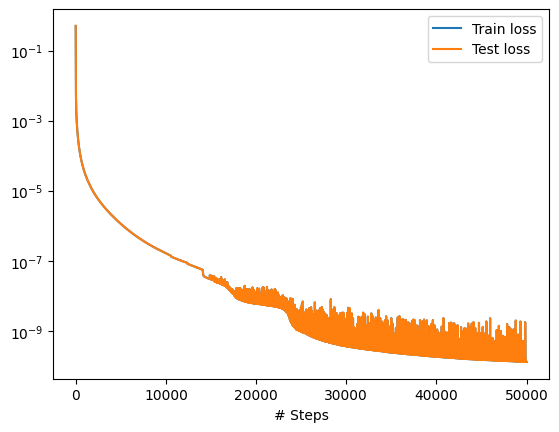

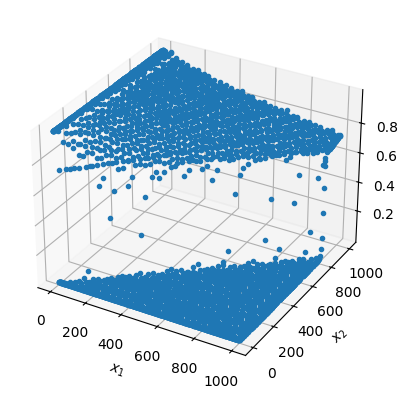

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [13]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 1.2949736494446067e-05
L2 relative error: 0.04144821108808235


### *2.13. Vẽ biểu đồ hiển thị các loss thành phần và loss tổng trong hàm loss function*

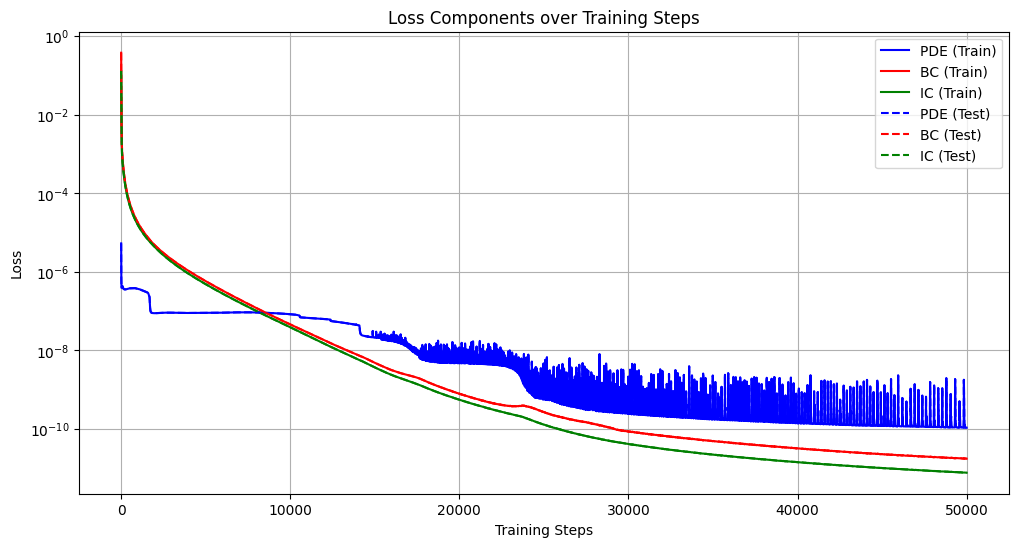

In [14]:
def visualize_loss_lines(losshistory):
    # Lấy dữ liệu từ losshistory
    steps = losshistory.steps
    train_loss = np.array(losshistory.loss_train)
    test_loss = np.array(losshistory.loss_test)

    # Tách các thành phần
    pde_train, bc_train, ic_train = train_loss[:, 0], train_loss[:, 1], train_loss[:, 2]
    pde_test, bc_test, ic_test = test_loss[:, 0], test_loss[:, 1], test_loss[:, 2]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))

    # Train loss
    plt.plot(steps, pde_train, 'b-', label='PDE (Train)')
    plt.plot(steps, bc_train, 'r-', label='BC (Train)')
    plt.plot(steps, ic_train, 'g-', label='IC (Train)')

    # Test loss
    plt.plot(steps, pde_test, 'b--', label='PDE (Test)')
    plt.plot(steps, bc_test, 'r--', label='BC (Test)')
    plt.plot(steps, ic_test, 'g--', label='IC (Test)')

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Components over Training Steps')
    plt.yscale('log') # Dùng thang log để thấy rõ sự giảm của loss
    plt.grid(True)
    plt.legend()
    plt.show()

# Gọi sau khi huấn luyện
visualize_loss_lines(losshistory)

### *2.14. Vẽ biểu đồ mặt tiến dầu nước theo thời gian*

In [15]:
# Dự đoán trên lưới
x = np.linspace(0, L, 500, dtype=np.float64)[:, None]
t = np.linspace(0, t_simulate, 500, dtype=np.float64)[:, None]
X, T = np.meshgrid(x, t)
X_flat = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
Sw_pred = model.predict(X_flat)
Sw_pred = Sw_pred.reshape(500, 500)

In [16]:
Sw_real = np.zeros((500, 500), dtype=np.float64)
for i in range (500):
    for j in range(500):
        Sw_real[i, j] = BL_exact_solution(j, i)

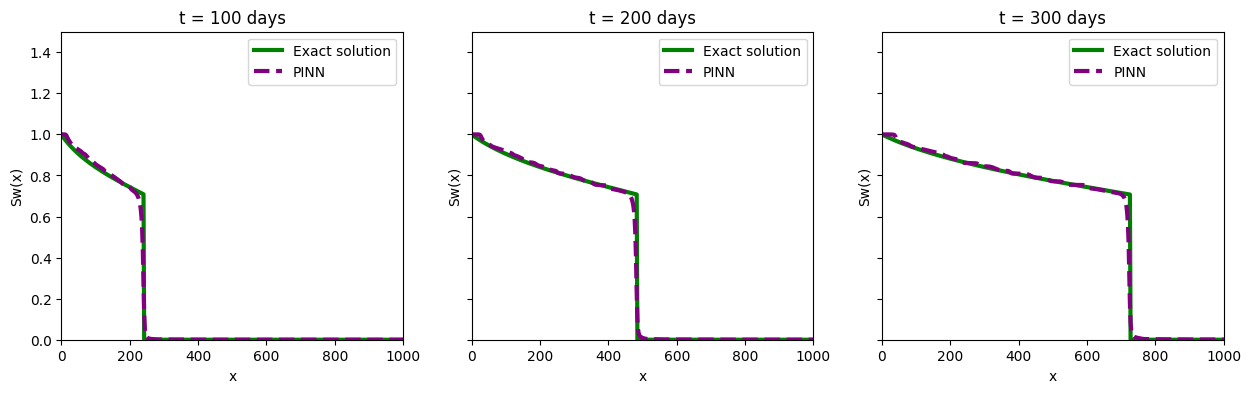

In [17]:
# Vẽ biểu đồ tĩnh tại các thời điểm cụ thể
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
t_especific = [100, 200, 300]

for i, t in enumerate(t_especific):
    index = int(t)
    axs[i].plot(x, Sw_real[index], color='green', ls='-', lw=3, label="Exact solution")
    axs[i].plot(x, Sw_pred[index], color='purple', ls='--', lw=3, label="PINN")
    axs[i].set_title(f"t = {t:.0f} days")
    axs[i].set_ylim(0, 1.5)
    axs[i].set_xlim(0, 1000)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('Sw(x)')
    axs[i].legend()
plt.show()

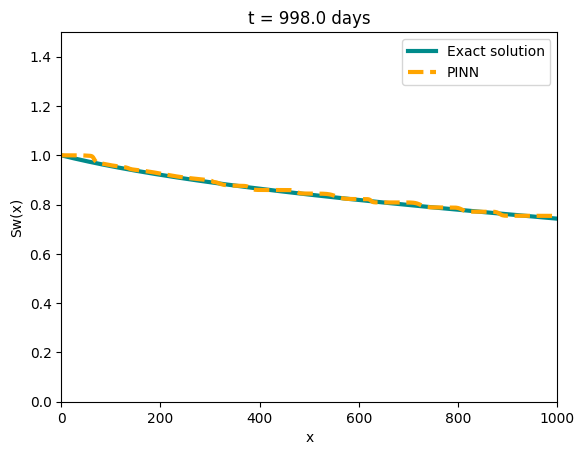

In [18]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

# Tải dữ liệu nghiệm chính xác và tạo dữ liệu đầu vào
X, y = gen_testdata()  # Lấy X (tọa độ không gian-thời gian) và y (nghiệm chính xác)
Sw_real = y.reshape(500, 500)  # Reshape nghiệm chính xác thành ma trận 500x500 (t_dim x x_dim)

# Dự đoán nghiệm từ mô hình PINNs
Sw_pred = model.predict(X)  # Dự đoán Sw tại các điểm X
Sw_pred = Sw_pred.reshape(500, 500)  # Reshape thành ma trận 500x500 (t_dim x x_dim)

# Chuẩn hóa lại x từ [0, L] về [0, 1] để vẽ đồ thị (nếu cần)
x_plot = np.linspace(0, L, 500, dtype=np.float64)  # Lưới không gian từ 0 đến L

# Tạo hoạt hình
fig = plt.figure()
ax = plt.axes(xlim=(0.0, 1000), ylim=(0.0, 1.5), xlabel='x', ylabel='Sw(x)')
line, = ax.plot([], [], color='darkcyan', ls='-', lw=3, label="Exact solution")
line2, = ax.plot([], [], color='orange', ls='--', lw=3, label="PINN")
ax.legend()

def init():
    line.set_data([], [])
    line2.set_data([], [])
    return line, line2

def animate(i):
    y = Sw_real[i, :]  # Nghiệm chính xác tại thời điểm t thứ i
    y2 = Sw_pred[i, :]  # Nghiệm PINNs tại thời điểm t thứ i
    line.set_data(x_plot, y)
    line2.set_data(x_plot, y2)
    ax.set_title(f"t = {round(i * t_simulate / 500, 2)} days")  # Thời gian tính theo t_simulate
    return line, line2

# Tạo hoạt hình với 500 khung hình
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=100, blit=True)
anim.save("result.gif", writer="pillow")

# Hiển thị biểu đồ (tùy chọn)
plt.show()

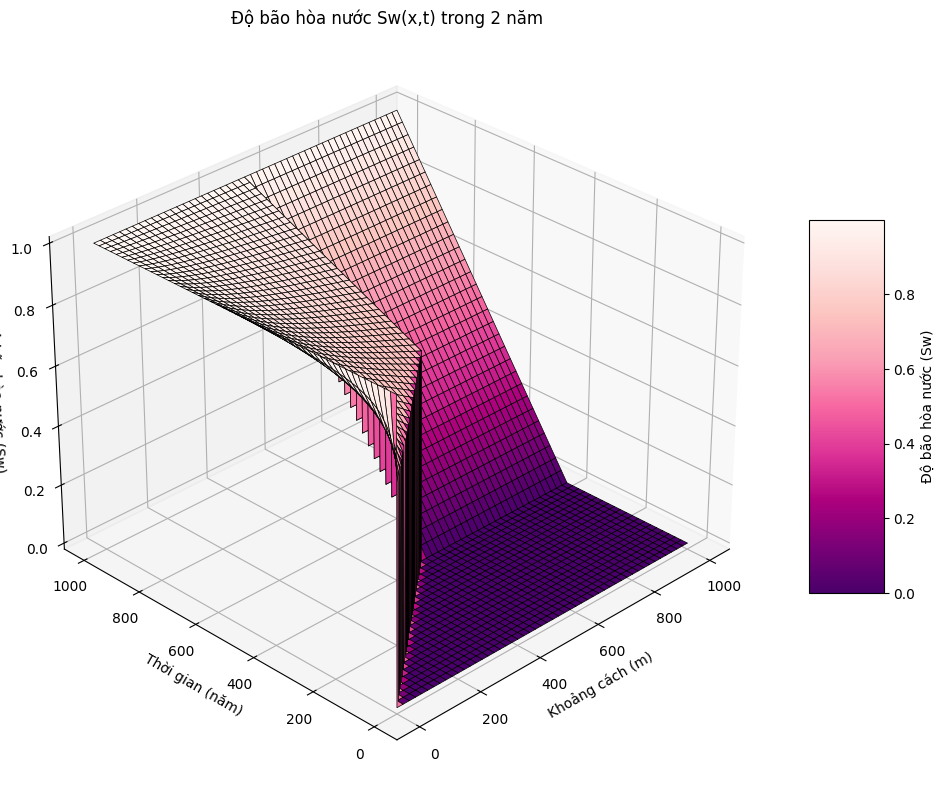

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Định nghĩa tham số
L = 1000.0  # Chiều dài vỉa (mét)
phi = 0.2   # Độ rỗng
v = 0.5     # Vận tốc Darcy (m/ngày)
t_max_original = L * phi / v  # Thời gian tối đa ban đầu: 400 ngày
nx = 500      # Số điểm không gian
nt = 500      # Số điểm thời gian ban đầu
nt_new = 1000 # Số điểm thời gian mới
t_max_new = 1000 # 2 năm, tính bằng ngày (730 ngày)

# Tạo lưới không gian và thời gian
x = np.linspace(0, L, nx)  # Không gian từ 0 đến L (mét)
t = np.linspace(0, t_max_original, nt)  # Thời gian từ 0 đến t_max_original (ngày)
time_physical_new = np.linspace(0, t_max_new, nt_new)  # Thời gian mới từ 0 đến 730 ngày
t_years = time_physical_new  # Chuyển sang năm

# Tạo u_n_pinn giả lập (dựa trên nghiệm Buckley-Leverett)
u_n_pinn = np.zeros((nt, nx))
for i in range(nt):
    for j in range(nx):
        t_phys = t[i]
        x_phys = x[j]
        if t_phys == 0:
            u_n_pinn[i, j] = 0
        elif x_phys == 0:
            u_n_pinn[i, j] = 1
        elif x_phys < (1/2) * (1 + np.sqrt(2)) * t_phys:
            e = x_phys / t_phys
            u_n_pinn[i, j] = (1/2) * (np.sqrt((-2*e + np.sqrt(4*e + 1) - 1)/e + 1) + 1)
        else:
            u_n_pinn[i, j] = 0

# Tạo u_n_pinn_extended cho 2 năm
u_n_pinn_extended = np.zeros((nt_new, nx))
for i in range(nt_new):
    t_phys = time_physical_new[i]
    if t_phys <= t_max_original:
        # Nội suy tuyến tính từ u_n_pinn dựa trên thời gian vật lý
        t_dimless = t_phys / t_max_original
        idx = int(t_dimless * (nt - 1))
        u_n_pinn_extended[i, :] = u_n_pinn[idx, :]
    else:
        # Ngoại suy tuyến tính từ giá trị cuối của u_n_pinn đến 1
        fraction = min((t_phys - t_max_original) / (t_max_new - t_max_original), 1.0)
        u_n_pinn_extended[i, :] = u_n_pinn[-1, :] + fraction * (1 - u_n_pinn[-1, :])

# Tạo lưới cho biểu đồ 3D
X, T = np.meshgrid(x, t_years)  # X: không gian (m), T: thời gian (năm)
u_grid = u_n_pinn_extended  # Dữ liệu độ bão hòa nước

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Khoảng cách (m)')
ax.set_ylabel('Thời gian (năm)')
ax.set_zlabel('Độ bão hòa nước (Sw)')
ax.set_zlim(0, 1)
ax.view_init(elev=30, azim=-135)

# Vẽ bề mặt với lưới và màu sắc (đỏ = 1, tím = 0)
surf = ax.plot_surface(X, T, u_grid, cmap='RdPu_r', edgecolor='k', linewidth=0.5, antialiased=True)

# Thêm thanh màu
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Độ bão hòa nước (Sw)')

plt.title('Độ bão hòa nước Sw(x,t) trong 2 năm')
plt.tight_layout()
plt.savefig("3d_surface_u.png")
plt.show()

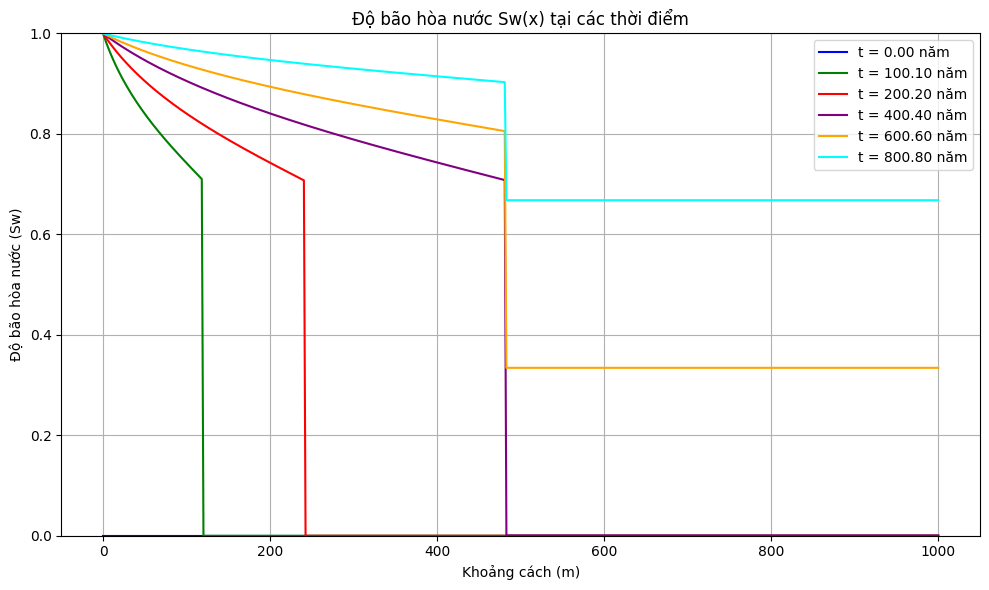

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# (Giữ nguyên phần tính toán u_n_pinn_extended từ code trước)

# Chọn một số thời điểm để vẽ
time_indices = [0, 100, 200, 400, 600, 800]  # Chỉ số thời gian
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'black']

plt.figure(figsize=(10, 6))
for idx, color in zip(time_indices, colors):
    plt.plot(x, u_n_pinn_extended[idx, :], label=f't = {t_years[idx]:.2f} năm', color=color)

plt.xlabel('Khoảng cách (m)')
plt.ylabel('Độ bão hòa nước (Sw)')
plt.title('Độ bão hòa nước Sw(x) tại các thời điểm')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("line_plot_sw.png")
plt.show()

### *2.15. Vẽ biểu đồ hiển thị lưu lượng nước bơm ép, lưu lượng nước khai thác và lưu lượng dầu khai thác*

### *2.16. Vẽ biểu đồ hiển thị tổng lượng nước bơm ép, tổng lượng nước khai thác và tổng lượng dầu đã khai thác theo thời gian*

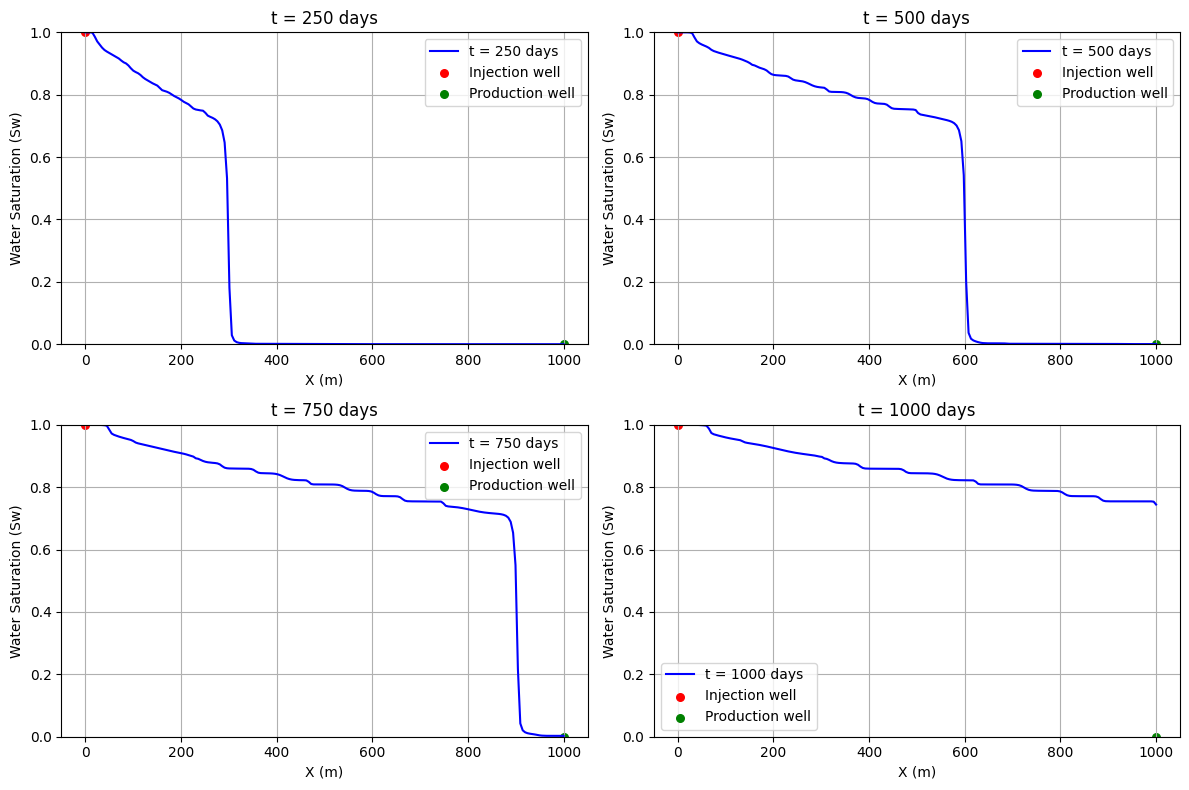

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_1d(model, times):
    x = np.linspace(0, L, 200)  # nhiều điểm hơn để đường mượt hơn
    
    n_cols = 2  # 2 hình 1 hàng
    n_rows = int(np.ceil(len(times) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    axes = axes.flatten()  # để dễ truy cập

    for idx, t in enumerate(times):
        points = np.vstack((x, np.full_like(x, t))).T  # Chỉ còn x và t
        Sw = model.predict(points).flatten()  # Dự đoán S_w tại (x, t)
        
        ax = axes[idx]
        ax.plot(x, Sw, label=f't = {t} days', color='blue')
        
        # Đánh dấu vị trí Injection và Production wells
        ax.scatter(0, 1.0, color='red', s=30, label='Injection well')  # Sw ≈ 1
        ax.scatter(L, 0.0, color='green', s=30, label='Production well')  # Sw ≈ 0
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Water Saturation (Sw)')
        ax.set_title(f't = {t} days')
        ax.set_ylim(0, 1)  # Sw trong khoảng 0-1
        ax.grid(True)
        ax.legend()

    # Nếu dư subplot thì xóa
    for idx in range(len(times), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Gọi hàm
times = [250, 500, 750, 1000]  # Các thời điểm cần vẽ
visualize_1d(model, times)


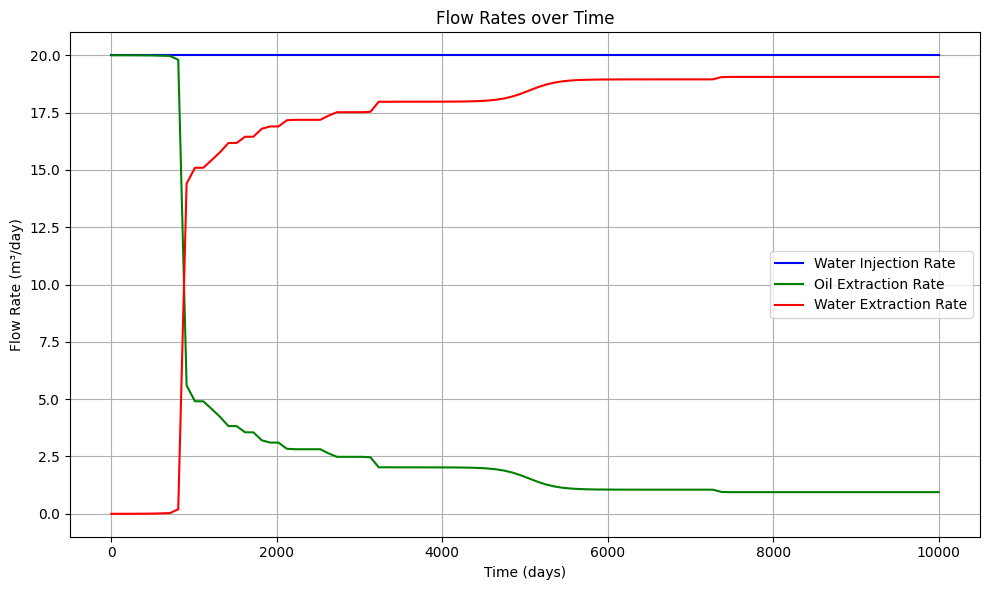

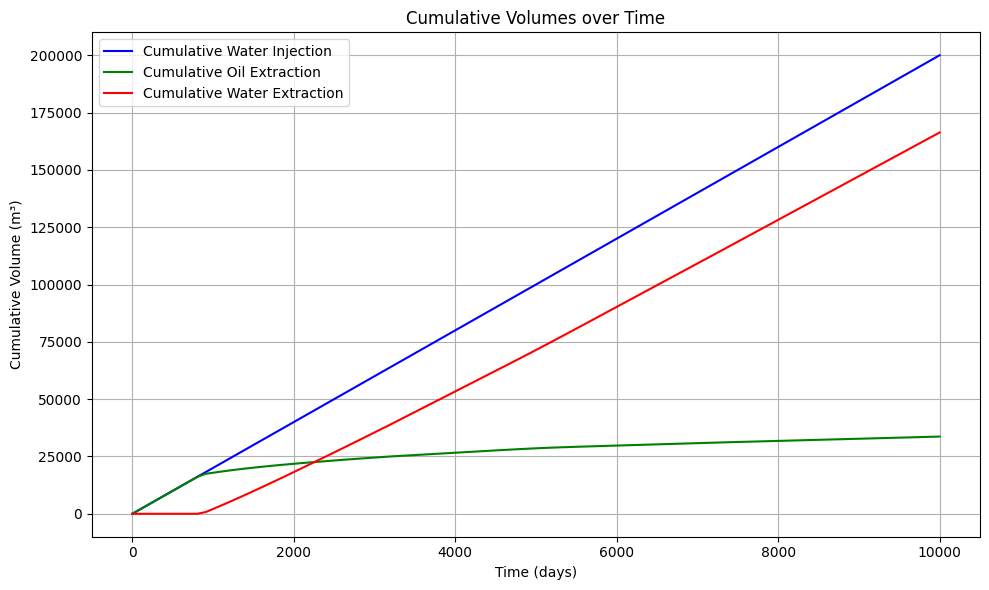

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid  # For numerical integration

# Hàm tính lưu lượng và thể tích
def calculate_flow_rates_and_volumes(model, time_points, production_loc=L):
    """
    Calculate flow rates and cumulative volumes at different time points for 1D reservoir.
    
    Parameters:
    - model: Trained DeepXDE model
    - time_points: Array of time points
    - production_loc: Location (x) of production well
    """
    # Water injection rate is constant
    water_injection_rate = np.full_like(time_points, Q_w_inj)
    
    # Calculate water saturation at production well
    prod_points = np.array([[production_loc, t] for t in time_points])  # Chỉ (x, t)
    water_saturation_prod = model.predict(prod_points).flatten()
    
    # Calculate oil and water extraction rates
    oil_extraction_rate = Q_prod * (1 - water_saturation_prod)
    water_extraction_rate = Q_prod * water_saturation_prod
    
    # Calculate cumulative volumes using numerical integration (trapezoidal rule)
    water_injection_volume = cumulative_trapezoid(water_injection_rate, time_points, initial=0)
    oil_extraction_volume = cumulative_trapezoid(oil_extraction_rate, time_points, initial=0)
    water_extraction_volume = cumulative_trapezoid(water_extraction_rate, time_points, initial=0)
    
    return {
        'time': time_points,
        'water_injection_rate': water_injection_rate,
        'oil_extraction_rate': oil_extraction_rate,
        'water_extraction_rate': water_extraction_rate,
        'water_injection_volume': water_injection_volume,
        'oil_extraction_volume': oil_extraction_volume,
        'water_extraction_volume': water_extraction_volume
    }

# Hàm vẽ thể tích tích lũy
def plot_cumulative_volumes(flow_data):
    """
    Plot cumulative volumes over time.
    
    Parameters:
    - flow_data: Dictionary with flow rates and volumes
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(flow_data['time'], flow_data['water_injection_volume'], 
            label='Cumulative Water Injection', color='blue')
    ax.plot(flow_data['time'], flow_data['oil_extraction_volume'], 
            label='Cumulative Oil Extraction', color='green')
    ax.plot(flow_data['time'], flow_data['water_extraction_volume'], 
            label='Cumulative Water Extraction', color='red')
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cumulative Volume (m³)')
    ax.set_title('Cumulative Volumes over Time')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Hàm vẽ lưu lượng
def plot_flow_rates(flow_data):
    """
    Plot flow rates over time.
    
    Parameters:
    - flow_data: Dictionary with flow rates and volumes
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(flow_data['time'], flow_data['water_injection_rate'], 
            label='Water Injection Rate', color='blue')
    ax.plot(flow_data['time'], flow_data['oil_extraction_rate'], 
            label='Oil Extraction Rate', color='green')
    ax.plot(flow_data['time'], flow_data['water_extraction_rate'], 
            label='Water Extraction Rate', color='red')
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Flow Rate (m³/day)')
    ax.set_title('Flow Rates over Time')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage
time_points = np.linspace(0, 10000, 100)

flow_data = calculate_flow_rates_and_volumes(model, time_points)

# Plot
fig_flow_rates = plot_flow_rates(flow_data)
fig_cumulative_volumes = plot_cumulative_volumes(flow_data)

plt.close(fig_flow_rates)
plt.close(fig_cumulative_volumes)


In [23]:
def create_dynamic_1d_visualization(model, time_range, num_frames=1000, resolution=200):
    """
    Create an animated GIF of water saturation over time for a 1D reservoir.
    
    Parameters:
    - model: Trained DeepXDE model
    - time_range: Tuple of (start_time, end_time)
    - num_frames: Number of frames in the animation
    - resolution: Number of points along the x-axis
    """
    from matplotlib.animation import FuncAnimation
    import numpy as np
    import matplotlib.pyplot as plt

    # Create x points
    x = np.linspace(0, L, resolution)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Time points
    start_time, end_time = time_range
    times = np.linspace(start_time, end_time, num_frames)
    
    # First frame data
    points = np.vstack([x, np.full_like(x, times[0])]).T  # Only (x, t)
    Sw_pred = model.predict(points).flatten()

    # Initialize plot
    line, = ax.plot(x, Sw_pred, color='blue')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, L)
    
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Water Saturation")
    title = ax.set_title(f"Time = {times[0]:.1f} days")
    ax.grid(True)

    def update(frame):
        """Update function for animation."""
        points = np.vstack([x, np.full_like(x, times[frame])]).T
        Sw_pred = model.predict(points).flatten()
        line.set_ydata(Sw_pred)
        title.set_text(f"Time = {times[frame]:.1f} days")
        return [line, title]

    # Create animation
    anim = FuncAnimation(fig, update, frames=num_frames, blit=True)
    
    # Save animation as GIF
    anim.save("water_saturation_1d.gif", writer='pillow', fps=10, dpi=100)
    
    plt.close(fig)
    print("Animation saved as 'water_saturation_1d.gif'")

# Example usage
dynamic_time_range = (0, 2000)
create_dynamic_1d_visualization(model, dynamic_time_range)


Animation saved as 'water_saturation_1d.gif'


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Tham số
nx = 100    # Số điểm lưới theo x
x = np.linspace(0, L, nx)
num_frames = 300
time_points = np.linspace(0, 2000, num_frames)  # Thời gian mô phỏng (days)

# Hàm dự đoán độ bão hòa nước trên lưới 1D tại một thời điểm nhất định
def get_water_saturation(model, x, t):
    # Ghép x và thời gian t vào thành điểm (x, t)
    points = np.vstack((x, np.full_like(x, t))).T
    Sw = model.predict(points).flatten()
    Sw = np.clip(Sw, 0, 1)
    return Sw

# Hàm tạo khung hình cho profile 1D
def create_frame(Sw, x, t, frame_idx):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, Sw, color='blue')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, L)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Water Saturation (Sw)')
    ax.set_title(f'Water Saturation Profile at t = {t:.0f} days')
    ax.grid(True)
    filename = f'frame_{frame_idx:03d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return filename

# Tạo các khung hình
frames = []
for i, t in enumerate(time_points):
    print(f"Đang tạo khung hình {i+1}/{num_frames}")
    Sw = get_water_saturation(model, x, t)
    frame_file = create_frame(Sw, x, t, i)
    frames.append(frame_file)

# Tạo GIF
gif_filename = 'reservoir_sw_simulation_1d.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        os.remove(frame)  # Xóa file khung hình tạm thời

print(f"GIF đã được lưu dưới tên {gif_filename}")


Đang tạo khung hình 1/300
Đang tạo khung hình 2/300
Đang tạo khung hình 3/300
Đang tạo khung hình 4/300
Đang tạo khung hình 5/300
Đang tạo khung hình 6/300
Đang tạo khung hình 7/300
Đang tạo khung hình 8/300
Đang tạo khung hình 9/300
Đang tạo khung hình 10/300
Đang tạo khung hình 11/300
Đang tạo khung hình 12/300
Đang tạo khung hình 13/300
Đang tạo khung hình 14/300
Đang tạo khung hình 15/300
Đang tạo khung hình 16/300
Đang tạo khung hình 17/300
Đang tạo khung hình 18/300
Đang tạo khung hình 19/300
Đang tạo khung hình 20/300
Đang tạo khung hình 21/300
Đang tạo khung hình 22/300
Đang tạo khung hình 23/300
Đang tạo khung hình 24/300
Đang tạo khung hình 25/300
Đang tạo khung hình 26/300
Đang tạo khung hình 27/300
Đang tạo khung hình 28/300
Đang tạo khung hình 29/300
Đang tạo khung hình 30/300
Đang tạo khung hình 31/300
Đang tạo khung hình 32/300
Đang tạo khung hình 33/300
Đang tạo khung hình 34/300
Đang tạo khung hình 35/300
Đang tạo khung hình 36/300
Đang tạo khung hình 37/300
Đang tạo k

C:\Users\User\AppData\Local\Temp\ipykernel_9416\3347037191.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF đã được lưu dưới tên reservoir_sw_simulation_1d.gif
